## whatsapp chat analyzer. From an exported .txt file, it can do some analysis. 
<br>
<br>
For example, who sends more messages, more audios, videos, etc.
<br>
<br>
The way we'll work with them is very simple, Whatsapp allows you to export chats into a .zip file that contains a .txt file with all of your chats, they have the following format.
<br>
<br>
[06/04/2020, 20:04:20] Sasha: Hi
[06/04/2020, 20:04:42] Fede: 😒😒😒
[06/04/2020, 20:04:57] Fede: image omitted
<br>
<br>
Whereas Android phones tend to have the following format.
<br>
<br>
9/1/18 15:00 - Federico: Ahhhh
<br>
<br>
This piece of code works best with iOS since android phones don't spit out nearly as much information.
<br>
<br>
There's the date, the name of the sender, and the message itself. Notice that when the message was an audio, image or video file, it will just say "Image omitted"(If the lenguage is not english, it'll write out the same message in a different language)



In [22]:
##THE DIRECTORY WHERE THE TXT FILE IS LOCATED.
file_name ="chat_prueba.txt"

In [23]:
import pandas as pd
import numpy as np
import math
pd.set_option('mode.chained_assignment', None) #

As we've seen before, the format of the program has the following format.

[06/04/2020, 20:04:20] Sasha: Hi

From this, we have to extract the date, the time, the name of the sender and the message itself. It's quite complicated to make it work in every single format that different phones could have, but the following code worked in all the ones I've tried.

In [24]:
import io
import re

def read_file(name):
    
#Here we read the txt file, while ignoring non ascii characters
    f = io.open(name, mode="r", encoding="utf-8",errors="ignore")
    x = f.read().split('\n') #We split on the \n, which isn't perfect, because it can sometimes show up in texts.
    x = x[0:(len(x)-1)] #Deletes the last empty element
    return x

In [25]:
#From the TXT file we will create a pandas dataframe.
def create_list(file):
    new_list = [] #The list of lists to be converted to a df
    ### The four different elements to be contained by the df.
    date_message = [] 
    sender = []
    text = []
    time_message = []
    #Here what we do is, we iterate through every element, and we split it into different pieces. The date, the sender and the message itself
    #Lastly we also add the hour when the message was sent.
    for element in x:
        problematic_characters = ["\u200f","\u200e","- "] #To avoid compatibility issues
        for character in problematic_characters:
            element = element.replace(character,"")
        split = element.split(" ",2)
        
        new_list.append(split)
    df = pd.DataFrame(new_list, columns = ["date","time","sender_text"])
    problematic_characters = ["[","]","\u200f","\u200e",",","-"]
    df["sender"] = df["sender_text"].str.split(":",1).str[0] #WE get all the info before the first :, which denotes the name of the sender
    df["text"] = df["sender_text"].str.split(":",1).str[1] #AFter it' we'll just get the message
    df = df.drop(["sender_text"], axis=1)
    for character in problematic_characters:
        df["sender"] = df["sender"].str.replace(character,"")
        df["time"] = df["time"].str.replace(character,"")
        df["date"] = df["date"].str.replace(character,"")
        
                
    #return date_message         
    return df

In [26]:
x = read_file(file_name) #Open up the file
df = create_list(x) #Make it into a df

In [27]:
df.head()

,date,time,sender,text
0,07/01/2017,16:49:21,Ullua,Messages and calls are end-to-end encrypted. ...
1,07/01/2017,16:49:22,Fede,"Hola, ¿Cómo va?"
2,07/01/2017,20:34:29,Ullua,bien man
3,07/01/2017,20:37:56,Ullua,se ve que hace un poquito de frío ahí jajaja
4,07/01/2017,20:38:16,Ullua,Cómo la estás pasando?


In [28]:
users = df["sender"].value_counts()[0:2].index.tolist() #We make sure to only use
#the two most important values, if you copy a text, it may show up as a separate message. Also, if there's a new line,
#it will try to interpret it as a text message, we make sure to get rid of all that.
df = df[df["sender"].isin(users)]

In [29]:
# We create a boolean to detect audios,videos,images,stickers, etc.
df["audio"] = np.where(df["text"] == ' audio omitted',True,False)
df["videos"] = np.where(df["text"] == ' video omitted',True,False)
df["images"] = np.where(df["text"] == ' image omitted',True,False)
df["sticker"] = np.where(df["text"] == ' sticker omitted',True,False)
df["android"] = np.where(df["text"] == ' multimedia omitted',True,False)
df["messages"] = 1
df["lenght_message"] = list(map(len,df["text"])) #To get the number of characters, we apply the len function to each one of the texts

Once we have all the relevant columns, we group by the senders name, and sum it up to see who sent more audios, messages, etc.

In [30]:
grouped = df.groupby("sender").sum()
grouped = grouped[grouped > 0].dropna(axis=1,how="all") #We sure sure to delete the colums with 0s
grouped = grouped.fillna(0).astype(int) #if there's any nas remaining, we replace them with zeros

In [31]:
grouped

,audio,videos,images,sticker,messages,lenght_message
sender,,,,,,
Fede,5809,110,1312,54,30790,587746
Ullua,7315,57,1341,58,31954,681780


Here we will plot all the information in the grouped dataframe.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8dadf1c40>,
      dtype=object)

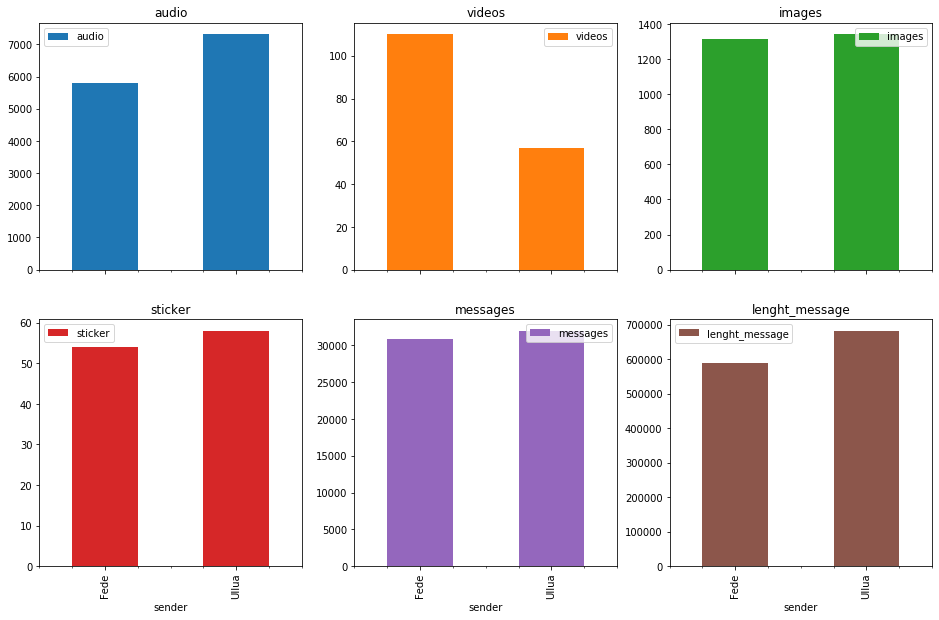

In [32]:
grouped.plot.bar(subplots=True,figsize=(16, 10),layout = (2 , math.ceil(grouped.shape[1]/2)))

A problem I've encountered converting the date to a pandas time element, is that it struggles when the format is not the US format.
Since I don't know the origin of the exported chat, we will use the following code to detect whether the day comes first or not. For that, we will grab the first two characters, and see if any of the elements is higher than 12, meaning we're dealing with days.

In [33]:
day_month = df["date"].str.get(0)+df["date"].str.get(1)
day_month = day_month.str.replace('[^0-9]','') #Remove all non numberic characters
if sum(day_month.astype(int) > 12) > 1:
    day_first=True
else:
    day_first=False

## TIME DATE.

Most of the information above, was related to the messages themselves, who sent the most stickers, audios, messages, etc.

The second part of this is about the most active moments in the chat, at what time do we chat the most? on what days? which months were the most active? etc.

In [34]:
#Fix problems when the time is of the format 16:41 instead of 16:41:00
if len(df["time"][0]) < 6:
    df["time"]=df["time"]+df["time"][0][-3]+"00" #We use string get 2 to keep the format

In [35]:
df["date1"] = pd.to_datetime(df["date"],dayfirst=day_first) #we convert the date to a datetime element
df["time1"] = pd.to_timedelta(df["time"]) #we convert time date to a timedelta element
df["hours"] = df["time1"].dt.components['hours']#we extract the hours
df["hours_full"] = df["time1"].dt.components['hours'] + df["time1"].dt.components['minutes']/60
df["weekday"] = df["date1"].dt.strftime("%w").astype("int") #We get the weekdays and convert them to integers
df["month"] = df["date1"].dt.strftime("%m").astype("int") #We get the month and convert them to integers 
df["year"] = df["date1"].dt.strftime("%Y").astype("int") #We get the year and convert them to integers

Once we have all the time information we need, we can group by all of them, to see which where the months, years, weekdays and hours where the chat was at the most active

In [36]:
grouped_by_month = df.groupby("month").sum()["messages"]
grouped_by_month= grouped_by_month.rename({1: 'January',2: "February ",3:"March",4:"April",5:"May",6:"June",7:"July",8:"August",9:"September",10:"October",11:"November",12:"December"},axis=0)
grouped_by_year = df.groupby("year").sum()["messages"]
grouped_by_hour = df.groupby("hours").sum()["messages"]
grouped_by_weekday = df.groupby("weekday").sum()["messages"]
grouped_by_weekday= grouped_by_weekday.rename({1: 'Tuesday',2: "Wednesday ",3:"Thursday",4:"Friday",5:"Saturday",6:"Sunday",0:"Monday"},axis=0)

# PLOTTING ALL THE RELEVANT INFORMATION

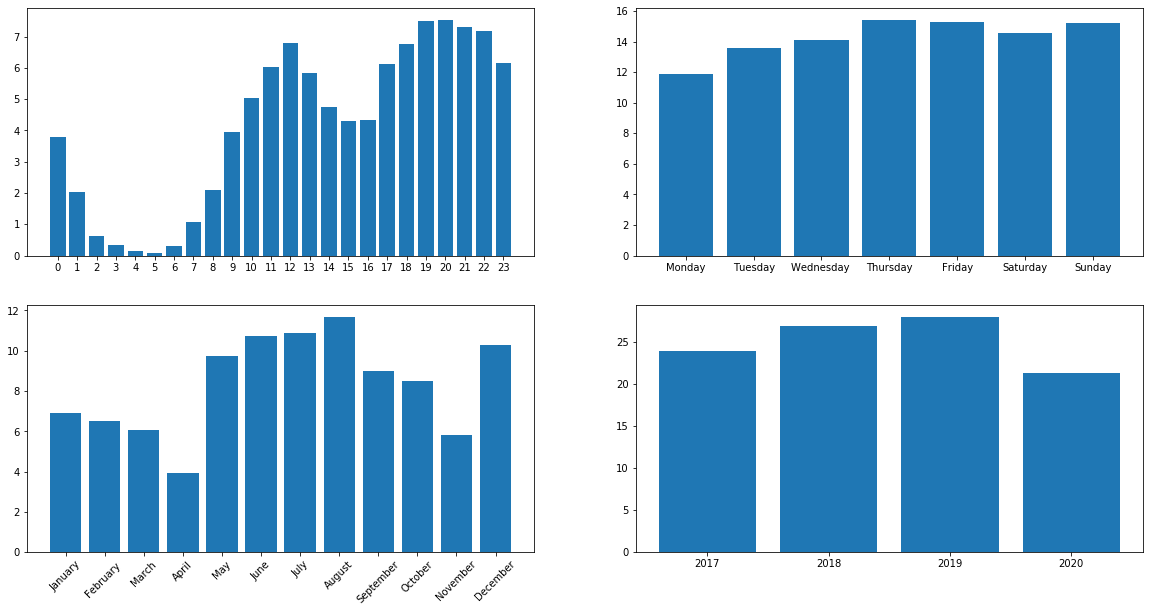

In [37]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
#WE will make sure to normalize all the plots

fig, [[axis1, axis2],[axis3, axis4]] = plt.subplots(2,2,figsize=(20,10))
axis1.bar(grouped_by_hour.index,(grouped_by_hour*100/sum(grouped_by_hour)))
axis1.set_xticks(grouped_by_hour.index)
axis2.bar(grouped_by_weekday.index,(grouped_by_weekday*100/sum(grouped_by_weekday)))
axis3.bar(grouped_by_month.index,(grouped_by_month*100/sum(grouped_by_month)))
axis3.set_xticklabels(grouped_by_month.index,rotation=45)
axis4.bar(grouped_by_year.index,(grouped_by_year*100/sum(grouped_by_year)))
#axis4.set_xlim(min(grouped_by_year.index), max(grouped_by_year.index))
axis4.xaxis.set_major_locator(MaxNLocator(integer=True)) #This is in order to avoid non integers ticks
plt.show()
